In [1]:
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import pingouin as pg

df = pd.read_csv('data/survey_results_public.csv')

##
## Stop outputs from using scientific notation
##
pd.set_option('display.float_format', '{:.6f}'.format)

##
## Filtering responses which are not professional software developers that provided compensation information
##
df.dropna(subset=['CompTotal'], inplace=True)
df = df[df['MainBranch'] == 'I am a developer by profession']
df = df[df['Employment'].str.contains('Employed, full-time', na=False)]
df = df[df['DevType'].str.contains('Developer', na=False)]

##
## Output row count for each country
##

country_count = df['Country'].value_counts()
country_count_df = country_count[country_count > 400].reset_index()
country_count_df.columns = ['Country', 'Count']
# display(country_count_df)
# country_count_df.to_csv('response_count.csv')

##
## Filtering responses which are not in USA, UK, Germany or Australia.
##
df = df[df[['Currency', 'Country']].apply(tuple, axis=1).isin([('USD\tUnited States dollar', 'United States of America'), 
                                                               ('EUR European Euro', 'Germany'), 
                                                               ('GBP\tPound sterling', 'United Kingdom of Great Britain and Northern Ireland'),
                                                               ('AUD\tAustralian dollar', 'Australia')])]



##
## Retain only the wanted columns.
##
df = df[['EdLevel',
         'LearnCode', 
         'LearnCodeOnline', 
         'YearsCode', 
         'YearsCodePro', 
         'DevType', 
         'Country', 
         'LanguageHaveWorkedWith', 
         'PlatformHaveWorkedWith', 
         'WebframeHaveWorkedWith',  
         'EmbeddedHaveWorkedWith', 
         'MiscTechHaveWorkedWith', 
         'ToolsTechHaveWorkedWith', 
         'WorkExp', 
         'ConvertedCompYearly']]

##
## Break the "HaveWorkdWith" columns down into a column for each language
##

WorkWithList = [
    'LanguageHaveWorkedWith', 
    'PlatformHaveWorkedWith', 
    'WebframeHaveWorkedWith', 
    'EmbeddedHaveWorkedWith',  
    'MiscTechHaveWorkedWith', 
    'ToolsTechHaveWorkedWith', 
]

for WorkWith in WorkWithList:
    df_workwith = df[WorkWith].str.get_dummies(sep=';')
    df_workwith = df_workwith.add_prefix(WorkWith + '_')
    df = pd.concat([df, df_workwith], axis=1)

##
## Split education level into individual columns
##

df_edulevel = pd.get_dummies(df['EdLevel'], prefix='EdLevel', columns=['primary', 'secondary', 'partialuni', 'associate', 'bachelor', 'master', 'professional'])

df_edulevel = df_edulevel.astype(int)

df_edulevel = df_edulevel.rename(columns={
    'EdLevel_Primary/elementary school': 'EdLevel_primary',
    'EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 'EdLevel_secondary',
    'EdLevel_Some college/university study without earning a degree': 'EdLevel_partialuni',
    'EdLevel_Associate degree (A.A., A.S., etc.)': 'EdLevel_associate',
    'EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'EdLevel_bachelor',
    'EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'EdLevel_master',
    'EdLevel_Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 'EdLevel_professional'
})

df_edulevel.loc[df_edulevel['EdLevel_professional'] == 1, 'EdLevel_master'] = 1
df_edulevel.loc[df_edulevel['EdLevel_master'] == 1, 'EdLevel_bachelor'] = 1
df_edulevel.loc[df_edulevel['EdLevel_bachelor'] == 1, 'EdLevel_associate'] = 1
df_edulevel.loc[df_edulevel['EdLevel_associate'] == 1, 'EdLevel_partialuni'] = 1
df_edulevel.loc[df_edulevel['EdLevel_partialuni'] == 1, 'EdLevel_secondary'] = 1
df_edulevel.loc[df_edulevel['EdLevel_secondary'] == 1, 'EdLevel_primary'] = 1

df = pd.concat([df, df_edulevel], axis=1)

##
## Drop known bad cols which contain very little to no data
##

cols_to_drop = [
    # 'PlatformWantToWorkWith_PythonAnywhere', 
    # 'WebframeWantToWorkWith_Yii 2', 
    'EmbeddedHaveWorkedWith_CUTE'
]
df = df.drop(columns=cols_to_drop)

##
## Create a dataframe per country
##

df_GER = df[df['Country'] == 'Germany']
df_UK  = df[df['Country'] == 'United Kingdom of Great Britain and Northern Ireland']
df_USA = df[df['Country'] == 'United States of America']
df_AU = df[df['Country'] == 'Australia']

##
## Remove Non Numeric Columns
##

df_GER = df_GER.select_dtypes(include='number')
df_UK  = df_UK.select_dtypes(include='number')
df_USA = df_USA.select_dtypes(include='number')
df_AU  = df_AU.select_dtypes(include='number')


In [2]:
##
## Perform a partical correlation between each variable and Total Compensation.
##

dependent = 'ConvertedCompYearly'

corr_array_list = []
for country, df in [["GER",df_GER], ["UK", df_UK], ["USA",df_USA], ["AU",df_AU]]:

    independent_list = df.columns.tolist()
    independent_list.remove(dependent)

    array = pd.DataFrame()
    for independent in independent_list:

        corr = pg.partial_corr(data=df, 
                               x=independent, 
                               y=dependent, 
                               method='spearman')
        corr.index.values[0] = independent
        array = pd.concat([array, corr])

    array = array.add_prefix(country + '_')
    corr_array_list.append(array)

corr_df = pd.concat(corr_array_list, axis=1)

corr_df['AVG_r'] = corr_df[['GER_r', 'USA_r', 'UK_r', 'AU_r']].mean(axis=1)
corr_df['AVG_p-val'] = corr_df[['GER_p-val', 'USA_p-val', 'UK_p-val', 'AU_p-val']].mean(axis=1)
corr_df = corr_df.sort_values(by='AVG_r', ascending=False)

# display(corr_df.loc['EdLevel_professional'])

corr_df.to_csv('calculated_correlations.csv')


/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:877: RuntimeWarning: invalid value encountered in divide
  / np.sqrt(np.abs(Vi_diag - Vi**2 / Vi_diag[..., None])).T
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/cameron/Documents/vscode/sci7420/venv/lib64/python3.11/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  #

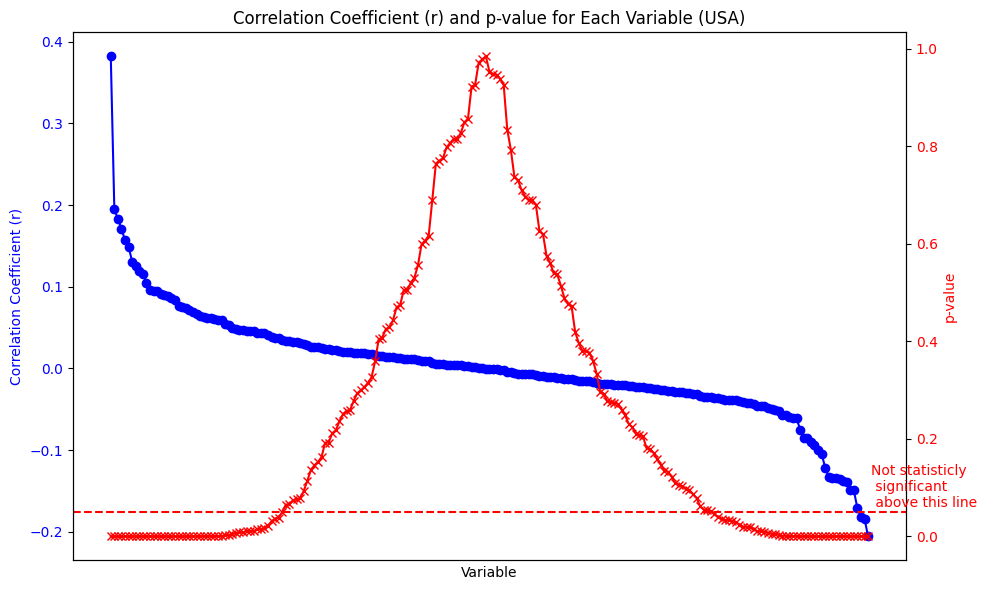

In [3]:
import matplotlib.pyplot as plt

corr_df = corr_df.sort_values(by='USA_r', ascending=False)

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Variable')
ax1.set_ylabel('Correlation Coefficient (r)', color='blue')
ax1.plot(corr_df.index, corr_df['USA_r'], marker='o', color='blue', label='r')
ax1.tick_params(axis='y', labelcolor='blue')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)


ax2 = ax1.twinx() 
ax2.set_ylabel('p-value', color='red')
ax2.plot(corr_df.index, corr_df['USA_p-val'], marker='x', color='red', label='p-val')
ax2.tick_params(axis='y', labelcolor='red')

ax2.axhline(y=0.05, color='red', linestyle='--', label='p-value cutoff (0.05)')
ax2.text(len(corr_df.index)-0.05, 0.05+0.01, 'Not statisticly \n significant \n above this line', color='red')

plt.title('Correlation Coefficient (r) and p-value for Each Variable (USA)')

# Display the plot
plt.tight_layout()
plt.savefig('randp.png', format='png')
plt.show()



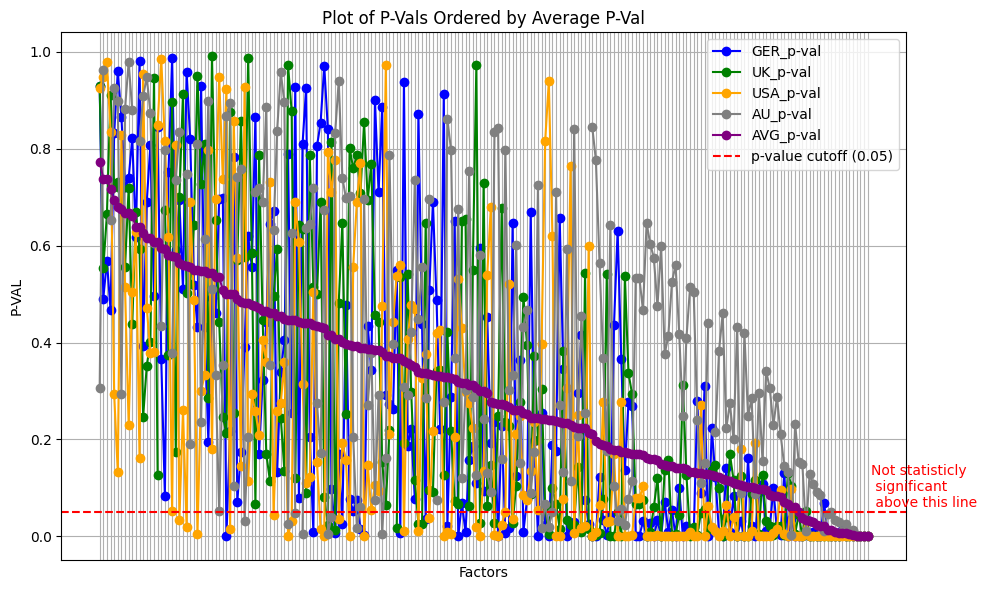

In [4]:
corr_df = corr_df.sort_values(by='AVG_p-val', ascending=False)

plt.figure(figsize=(10, 6))

plt.plot(corr_df.index, corr_df['GER_p-val'], marker='o', label='GER_p-val', color='blue')
plt.plot(corr_df.index, corr_df['UK_p-val'], marker='o', label='UK_p-val', color='green')
plt.plot(corr_df.index, corr_df['USA_p-val'], marker='o', label='USA_p-val', color='orange')
plt.plot(corr_df.index, corr_df['AU_p-val'], marker='o', label='AU_p-val', color='grey')
plt.plot(corr_df.index, corr_df['AVG_p-val'], marker='o', label='AVG_p-val', color='purple')

plt.axhline(y=0.05, color='red', linestyle='--', label='p-value cutoff (0.05)')
plt.text(len(corr_df.index)-0.05, 0.05+0.01, 'Not statisticly \n significant \n above this line', color='red')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

plt.xlabel('Factors')
plt.ylabel('P-VAL')
plt.title('Plot of P-Vals Ordered by Average P-Val')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('regionalpvalue.png', format='png')
plt.show()


In [5]:
corr_df_sig_all = corr_df.loc[((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05) & (corr_df['AU_p-val'] < 0.05))]
corr_df_sig_all = corr_df_sig_all.drop(columns=['GER_n', 'UK_n', 'USA_n', 'AU_n', 'GER_CI95%', 'UK_CI95%', 'USA_CI95%', 'AU_CI95%'])
corr_df_sig_all = corr_df_sig_all.sort_values(by='AVG_r', ascending=False)

In [6]:
display(corr_df_sig_all)

,GER_r,GER_p-val,UK_r,UK_p-val,USA_r,USA_p-val,AU_r,AU_p-val,AVG_r,AVG_p-val
WorkExp,0.514256,0.000000,0.412203,0.000000,0.382118,0.000000,0.430147,0.000000,0.434681,0.000000
ToolsTechHaveWorkedWith_Terraform,0.198164,0.000000,0.167319,0.000000,0.183067,0.000000,0.124752,0.026347,0.168326,0.006587
ToolsTechHaveWorkedWith_Kubernetes,0.157696,0.000000,0.219061,0.000000,0.157023,0.000000,0.119103,0.034028,0.163221,0.008507
MiscTechHaveWorkedWith_Apache Kafka,0.125133,0.000014,0.163341,0.000001,0.149304,0.000000,0.197993,0.000391,0.158943,0.000101
ToolsTechHaveWorkedWith_Homebrew,0.095859,0.000876,0.122910,0.000185,0.170613,0.000000,0.184254,0.000981,0.143409,0.000510
ToolsTechHaveWorkedWith_Docker,0.073619,0.010674,0.151586,0.000004,0.118815,0.000000,0.146483,0.009005,0.122626,0.004921
LanguageHaveWorkedWith_Go,0.070691,0.014232,0.100121,0.002350,0.125164,0.000000,0.140733,0.012132,0.109177,0.007179
MiscTechHaveWorkedWith_.NET Framework (1.0 - 4.8),-0.078447,0.006506,-0.130054,0.000075,-0.170868,0.000000,-0.111637,0.047033,-0.122752,0.013404
LanguageHaveWorkedWith_JavaScript,-0.196424,0.000000,-0.116793,0.000383,-0.137608,0.000000,-0.138596,0.013518,-0.147355,0.003475
LanguageHaveWorkedWith_PHP,-0.176109,0.000000,-0.167646,0.000000,-0.149162,0.000000,-0.164482,0.003314,-0.164350,0.000829


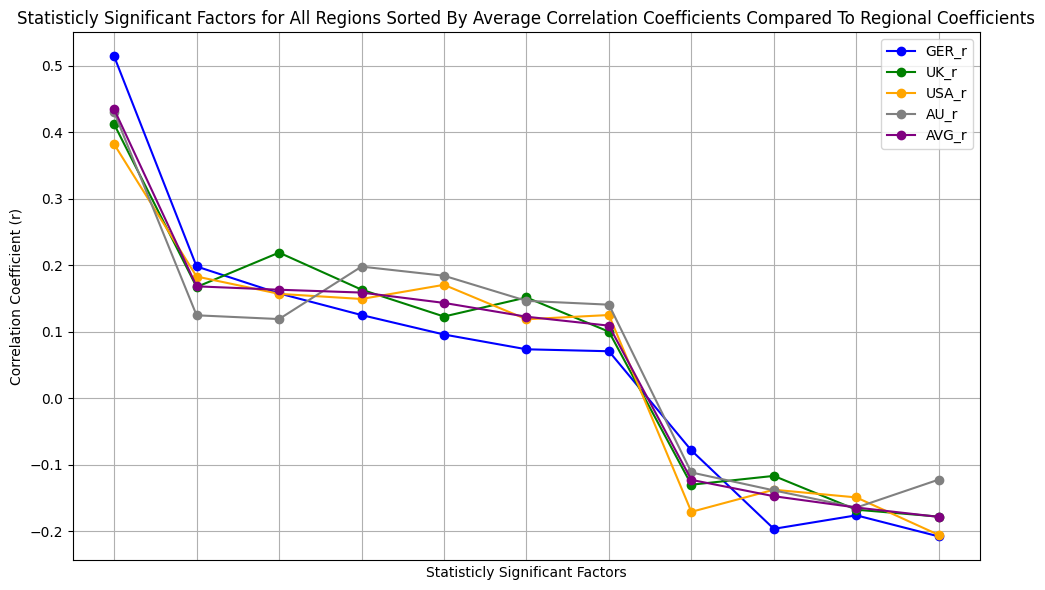

In [7]:
plt.figure(figsize=(10, 6))

plt.plot(corr_df_sig_all.index, corr_df_sig_all['GER_r'], marker='o', label='GER_r', color='blue')
plt.plot(corr_df_sig_all.index, corr_df_sig_all['UK_r'], marker='o', label='UK_r', color='green')
plt.plot(corr_df_sig_all.index, corr_df_sig_all['USA_r'], marker='o', label='USA_r', color='orange')
plt.plot(corr_df_sig_all.index, corr_df_sig_all['AU_r'], marker='o', label='AU_r', color='grey')
plt.plot(corr_df_sig_all.index, corr_df_sig_all['AVG_r'], marker='o', label='AVG_r', color='purple')

# Remove xticks
ax1.set_xticklabels([])
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

plt.xlabel('Statisticly Significant Factors')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Statisticly Significant Factors for All Regions Sorted By Average Correlation Coefficients Compared To Regional Coefficients')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('siginallcoefficients.png', format='png')
plt.show()


In [8]:
corr_df_sig_us = corr_df.loc[~((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05) & (corr_df['AU_p-val'] < 0.05))]
corr_df_sig_us = corr_df_sig_us.loc[((corr_df['USA_p-val'] < 0.05))]
corr_df_sig_us = corr_df_sig_us.loc[((corr_df['USA_r'] > 0.1))]
corr_df_sig_us = corr_df_sig_us.drop(columns=['GER_n', 'UK_n', 'USA_n', 'AU_n', 'GER_CI95%', 'UK_CI95%', 'USA_CI95%', 'AU_CI95%', 'GER_p-val', 'UK_p-val', 'USA_p-val', 'AU_p-val', 'AVG_p-val'])
corr_df_sig_us = corr_df_sig_us.sort_values(by='USA_r', ascending=False)
display(corr_df_sig_us)

,GER_r,UK_r,USA_r,AU_r,AVG_r
PlatformHaveWorkedWith_Amazon Web Services (AWS),0.201221,0.186091,0.194690,0.081035,0.165759
EdLevel_master,0.315944,0.133310,0.130262,0.045489,0.156251
LanguageHaveWorkedWith_Ruby,0.093294,0.033283,0.116040,0.065094,0.076928
ToolsTechHaveWorkedWith_Make,0.055577,0.133135,0.105124,0.035826,0.082415


In [9]:
corr_df_sig_uk = corr_df.loc[~((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05) & (corr_df['AU_p-val'] < 0.05))]
corr_df_sig_uk = corr_df_sig_uk.loc[((corr_df['UK_p-val'] < 0.05))]
corr_df_sig_uk = corr_df_sig_uk.loc[((corr_df['UK_r'] > 0.1))]
corr_df_sig_uk = corr_df_sig_uk.drop(columns=['GER_n', 'UK_n', 'USA_n', 'AU_n', 'GER_CI95%', 'UK_CI95%', 'USA_CI95%', 'AU_CI95%', 'GER_p-val', 'UK_p-val', 'USA_p-val', 'AU_p-val', 'AVG_p-val'])
corr_df_sig_uk = corr_df_sig_uk.sort_values(by='UK_r', ascending=False)
display(corr_df_sig_uk)

,GER_r,UK_r,USA_r,AU_r,AVG_r
PlatformHaveWorkedWith_Amazon Web Services (AWS),0.201221,0.186091,0.194690,0.081035,0.165759
EdLevel_bachelor,0.283945,0.158804,0.088624,0.029646,0.140255
PlatformHaveWorkedWith_Google Cloud,0.099580,0.155989,0.090843,0.025879,0.093073
EdLevel_associate,0.285089,0.148694,0.045865,0.041626,0.130319
EdLevel_master,0.315944,0.133310,0.130262,0.045489,0.156251
ToolsTechHaveWorkedWith_Make,0.055577,0.133135,0.105124,0.035826,0.082415
LanguageHaveWorkedWith_Groovy,0.079601,0.128558,0.047415,-0.036773,0.054700
EmbeddedHaveWorkedWith_Catch2,0.026045,0.127435,0.019481,-0.107573,0.016347
EmbeddedHaveWorkedWith_Boost.Test,0.022461,0.124523,-0.024609,-0.091282,0.007773
ToolsTechHaveWorkedWith_Pulumi,0.057992,0.105890,0.038728,-0.026166,0.044111


In [10]:
corr_df_sig_ger = corr_df.loc[~((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05) & (corr_df['AU_p-val'] < 0.05))]
corr_df_sig_ger = corr_df_sig_ger.loc[((corr_df['GER_p-val'] < 0.05))]
corr_df_sig_ger = corr_df_sig_ger.loc[((corr_df['GER_r'] > 0.1))]
corr_df_sig_ger = corr_df_sig_ger.drop(columns=['GER_n', 'UK_n', 'USA_n', 'AU_n', 'GER_CI95%', 'UK_CI95%', 'USA_CI95%', 'AU_CI95%', 'GER_p-val', 'UK_p-val', 'USA_p-val', 'AU_p-val', 'AVG_p-val'])
corr_df_sig_ger = corr_df_sig_ger.sort_values(by='UK_r', ascending=False)
display(corr_df_sig_ger)

,GER_r,UK_r,USA_r,AU_r,AVG_r
PlatformHaveWorkedWith_Amazon Web Services (AWS),0.201221,0.186091,0.194690,0.081035,0.165759
EdLevel_bachelor,0.283945,0.158804,0.088624,0.029646,0.140255
EdLevel_associate,0.285089,0.148694,0.045865,0.041626,0.130319
EdLevel_master,0.315944,0.133310,0.130262,0.045489,0.156251
EdLevel_partialuni,0.250223,0.097982,0.047313,-0.016036,0.094871
LanguageHaveWorkedWith_Scala,0.109548,0.094396,0.096072,0.032868,0.083221
ToolsTechHaveWorkedWith_Google Test,0.111460,0.069847,0.018368,0.030101,0.057444
EmbeddedHaveWorkedWith_LLVM's Clang,0.114205,0.066005,0.059762,-0.080537,0.039859
EdLevel_professional,0.141278,0.061895,0.061535,-0.031677,0.058258
EdLevel_secondary,0.100089,0.060308,0.011260,0.023674,0.048833


In [11]:
corr_df_sig_au = corr_df.loc[~((corr_df['GER_p-val'] < 0.05) & (corr_df['USA_p-val'] < 0.05) & (corr_df['UK_p-val'] < 0.05) & (corr_df['AU_p-val'] < 0.05))]
corr_df_sig_au = corr_df_sig_au.loc[((corr_df['AU_p-val'] < 0.05))]
corr_df_sig_au = corr_df_sig_au.loc[((corr_df['AU_r'] > 0.1))]
corr_df_sig_au = corr_df_sig_au.drop(columns=['GER_n', 'UK_n', 'USA_n', 'AU_n', 'GER_CI95%', 'UK_CI95%', 'USA_CI95%', 'AU_CI95%', 'GER_p-val', 'UK_p-val', 'USA_p-val', 'AU_p-val', 'AVG_p-val'])
corr_df_sig_au = corr_df_sig_au.sort_values(by='UK_r', ascending=False)
display(corr_df_sig_au)

,GER_r,UK_r,USA_r,AU_r,AVG_r
ToolsTechHaveWorkedWith_Yarn,0.013893,0.064556,0.069670,0.120971,0.067273
LanguageHaveWorkedWith_Solidity,0.002644,0.051130,0.007171,0.111174,0.043030
LanguageHaveWorkedWith_Objective-C,-0.042947,-0.020378,0.058743,0.127747,0.030791
